In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision

from datetime import datetime
from collections import OrderedDict

In [2]:
import pickle

In [3]:
PATH = Path("/data2/yinterian/multi-task-romain")

In [4]:
gap = "15min"
gap

'15min'

In [5]:
filename = "data_train_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    train = pickle.load(f)

In [6]:
filename = "data_valid_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    valid = pickle.load(f)

In [7]:
train.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
0,10013,10013_15,1,87,49,7,3,1,0,1,104.56,64.26,"[[95.8, 93.0, 103.8, 34.8, 54.8], [99.2, 93.9,...",0
1,10013,10013_16,1,87,49,7,3,1,0,1,102.08,68.28,"[[106.7, 95.3, 115.4, 41.5, 65.0], [107.4, 95....",0
2,10013,10013_19,1,87,49,7,3,1,0,1,100.22,65.62,"[[95.4, 92.0, 133.3, 56.1, 83.0], [98.2, 91.9,...",0
3,10013,10013_20,1,87,49,7,3,1,0,1,106.44,57.74,"[[100.0, 94.6, 108.4, 39.0, 63.1], [102.3, 94....",0
4,10013,10013_22,1,87,49,7,3,1,0,1,93.88,56.74,"[[99.8, 91.6, 89.9, 37.7, 57.0], [99.3, 91.1, ...",0


In [8]:
valid.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
1000,11018,11018_23,0,67,47,1,1,0,0,0,76.04,69.9867,"[[79.0, 96.0, 98.0, 60.0, 71.0], [80.0, 95.0, ...",1
1001,11018,11018_24,0,67,47,1,1,0,0,0,75.24,74.6167,"[[77.0, 97.0, 99.0, 59.0, 72.0], [75.0, 97.0, ...",1
1002,11018,11018_26,0,67,47,1,1,0,0,0,81.42,80.19,"[[81.0, 96.0, 109.0, 66.0, 80.0], [80.0, 96.0,...",1
1003,11018,11018_27,0,67,47,1,1,0,0,0,81.3867,83.5367,"[[80.0, 94.0, 113.0, 65.0, 80.0], [83.0, 94.0,...",1
1004,11018,11018_28,0,67,47,1,1,0,0,0,79.7367,82.6133,"[[84.0, 95.0, 114.0, 67.0, 81.0], [81.0, 94.0,...",1


In [9]:
train.shape, valid.shape

((42830, 14), (5069, 14))

In [10]:
subject_id_list = np.sort(np.unique(train.subject_id.values))
id2index = {v: k+1 for k,v in enumerate(subject_id_list)}
num_subjects = len(subject_id_list)

In [11]:
num_subjects

2170

## Dataset

In [12]:
def get_mean_std_series(train):
    ss = np.concatenate(train.series.values)
    ss = ss.reshape(-1,5)
    return ss.mean(axis=0), ss.std(axis=0)

In [13]:
def get_mean_std_static(train):
    res = {}
    for name in ["age", "sapsii", "sofa"]:
        values = train[name].values
        res[name] = (values.mean(), values.std())
    res["series"] = get_mean_std_series(train)
    return res

In [14]:
norm_dict = get_mean_std_static(train)
norm_dict 

{'age': (64, 15.087455295966063),
 'sapsii': (33, 14.265492481117855),
 'sofa': (4, 3.7831641172054082),
 'series': (array([ 83.19453341,  93.64397046, 121.07613603,  58.73969887,
          78.6694367 ]),
  array([16.08727268, 17.53684697, 21.3399693 , 12.26982071, 14.36323955]))}

In [15]:
care2id = {v:k for k,v in enumerate(np.unique(train.care_unit.values))}
care2id 

{1: 0, 2: 1, 3: 2, 5: 3, 6: 4}

In [41]:
class MultiTask(Dataset):
    def __init__(self, df, norm_dict, id2index, care2id,  k=20, train=True):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.df["care_unit"] = self.df["care_unit"].apply(lambda x: care2id[x])
        self.names = ["age", "sapsii", "sofa"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]
        self.id2index = id2index
        self.train = train
        self.df_sample = self.pick_a_sample(k)
            
    def pick_a_sample(self, k=20):
        """ Picks sample with the same number of observations per patient"""
        #if not self.train: # fix seed for validation and test
        #    np.random.seed(3)
        sample = self.df.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(k, replace=True))
        sample = sample.copy()
        if self.train:
            self.subject_index = [self.id2index[subject_id] for subject_id in sample.subject_id.values]
            self.random = np.random.choice(2, sample.shape[0], p=[0.1, 0.9])
            self.subject_index = self.subject_index*self.random
        return sample

    def __getitem__(self, index):
        row = self.df_sample.iloc[index,:]
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        subject_index = 0
        if self.train:
            subject_index = self.subject_index[index]
        x_cat = np.array([row["care_unit"], subject_index])
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["prediction_mean_HR"], row["prediction_mean_MAP"]

    def __len__(self):
        return self.df_sample.shape[0]

In [17]:
train_ds = MultiTask(train, norm_dict, id2index, care2id)
valid_ds = MultiTask(valid, norm_dict, id2index, care2id, train=False)

In [18]:
x1, x2, x3, y1, y2 = train_ds[12]

In [19]:
x3

array([1, 1])

In [20]:
id2index[10320]

256

In [21]:
batch_size = 30
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [22]:
x_series, x_cont, x_cat, y1, y2 = next(iter(train_dl))

In [23]:
x_series = x_series.cuda()

In [24]:
x_series.shape

torch.Size([30, 30, 5])

In [25]:
x_cont.shape

torch.Size([30, 7])

In [26]:
y1

tensor([ 65.7072,  81.4600,  87.9800,  92.0600, 100.5808,  94.4268,  65.3700,
         96.0000, 104.3668,  83.9398,  79.2033, 102.2298,  97.8898,  76.0967,
         90.8400, 114.3667,  82.1900,  76.6370,  70.6333,  82.4036,  53.7267,
         86.8800,   0.0000,  70.5032,  89.4868,  72.0633,  73.7033,  60.0000,
        110.1500,  77.2400])

In [27]:
y2

tensor([ 99.2276, 115.2200,  76.0200, 133.0000,  66.2254,  91.8836,  77.0000,
         88.3400,  67.8270,  77.7462,  76.0000,  90.8640,  63.3972,  84.0000,
        101.0000,  97.0000,  66.0000,  57.5242,  71.5333,  68.0034,  63.0000,
        102.5200,  70.3800,  63.9898, 119.3696, 100.6667,  91.2367,  70.1933,
         88.2433,  76.9800])

In [28]:
x_cat.shape

torch.Size([30, 2])

## Model

In [29]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [30]:
class EventModel1(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel1, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 10 + 1 + 5
        self.linear1 = nn.Linear(7, 10)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(10)

    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x_cont = self.bn1(F.relu(self.linear1(x_cont))) 
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        return self.out1(x), self.out2(x)

In [31]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat1 = []
    ys1 = []
    y_hat2 = []
    ys2 = []
    for x_series, x_cont, x_cat, y1, y2 in valid_dl:
        batch = y1.shape[0]
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
        mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
        mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
        loss = mse_loss1 + mse_loss2
        sum_loss += batch*(loss.item())
        total += batch
        y_hat1.append(out1.view(-1).detach().cpu().numpy())
        ys1.append(y1.view(-1).cpu().numpy())
        y_hat2.append(out2.view(-1).detach().cpu().numpy())
        ys2.append(y2.view(-1).cpu().numpy())
    
    y_hat1 = np.concatenate(y_hat1)
    y_hat2 = np.concatenate(y_hat2)
    ys1 = np.concatenate(ys1)
    ys2 = np.concatenate(ys2)
    r2_1 = metrics.r2_score(ys1, y_hat1)
    r2_2 = metrics.r2_score(ys2, y_hat2)
    return sum_loss/total, r2_1, r2_2

In [32]:
def train_epochs(model, train_ds, optimizer, filename, lr=1e-3, epochs = 30):
    prev_val_r2 = 0
    for i in range(epochs):
        sum_loss1 = 0
        sum_loss2 = 0
        total = 0
        train_ds.pick_a_sample()
        train_dl = DataLoader(train_ds, batch_size=5000, shuffle=True)
        for x_series, x_cont, x_cat, y1, y2 in train_dl:
            model.train()
            x_series = x_series.float().cuda()
            x_cont = x_cont.float().cuda()
            x_cat = x_cat.long().cuda()
            y1 = y1.float().cuda()
            y2 = y2.float().cuda()
            out1, out2 = model(x_series, x_cont, x_cat)
            mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
            mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
            loss = mse_loss1 + mse_loss2
            sum_loss1 += len(y1) * mse_loss1.item()
            sum_loss2 += len(y1) * mse_loss2.item()
            total += len(y1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 1 == 0:
            val_loss, val_r2_1, val_r2_2 = val_metrics(model, valid_dl)
            print("\tTrain loss: {:.3f} {:.3f} valid loss: {:.3f} valid r2 hr {:.3f} valid r2 map {:.3f}".format(
                sum_loss1/total, sum_loss2/total, val_loss, val_r2_1, val_r2_2))
            
        if val_r2_1 > prev_val_r2:
            prev_val_r2 = val_r2_1
            if val_r2_1 > 0.7:
                path = "{0}/models/{1}_r2_{2:.0f}_{3:.0f}.pth".format(PATH, filename, 100*val_r2_1, 100*val_r2_2) 
                save_model(model, path)
                print(path)

In [33]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [34]:
model = EventModel1().cuda()

In [35]:
val_metrics(model, valid_dl)

(13702.715812683105, -26.224443227188655, -30.354568292723446)

In [36]:
# 0s in training
model = EventModel1().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model1_15min", epochs=15)

	Train loss: 5147.211 4469.503 valid loss: 4327.131 valid r2 hr -8.136 valid r2 map -8.168
	Train loss: 1242.111 943.046 valid loss: 402.417 valid r2 hr 0.155 valid r2 map 0.142
	Train loss: 242.910 232.833 valid loss: 881.007 valid r2 hr -0.657 valid r2 map -1.143
	Train loss: 212.862 158.328 valid loss: 248.976 valid r2 hr 0.433 valid r2 map 0.529
	Train loss: 79.515 62.906 valid loss: 222.345 valid r2 hr 0.547 valid r2 map 0.506
	Train loss: 73.210 73.685 valid loss: 124.243 valid r2 hr 0.758 valid r2 map 0.709
/data2/yinterian/multi-task-romain/models/model1_15min_r2_76_71.pth
	Train loss: 43.107 48.549 valid loss: 116.986 valid r2 hr 0.793 valid r2 map 0.697
/data2/yinterian/multi-task-romain/models/model1_15min_r2_79_70.pth
	Train loss: 36.361 43.455 valid loss: 107.935 valid r2 hr 0.798 valid r2 map 0.737
/data2/yinterian/multi-task-romain/models/model1_15min_r2_80_74.pth
	Train loss: 32.285 38.191 valid loss: 96.258 valid r2 hr 0.816 valid r2 map 0.770
/data2/yinterian/multi-ta

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer,filename="model1_15min", epochs=20)

	Train loss: 22.978 26.384 valid loss: 66.983 valid r2 hr 0.875 valid r2 map 0.836
/data2/yinterian/multi-task-romain/models/model1_15min_r2_87_84.pth
	Train loss: 19.653 22.775 valid loss: 58.882 valid r2 hr 0.887 valid r2 map 0.860
/data2/yinterian/multi-task-romain/models/model1_15min_r2_89_86.pth
	Train loss: 16.301 20.550 valid loss: 54.326 valid r2 hr 0.894 valid r2 map 0.873
/data2/yinterian/multi-task-romain/models/model1_15min_r2_89_87.pth
	Train loss: 15.020 19.343 valid loss: 51.617 valid r2 hr 0.900 valid r2 map 0.878
/data2/yinterian/multi-task-romain/models/model1_15min_r2_90_88.pth
	Train loss: 14.016 18.302 valid loss: 46.860 valid r2 hr 0.916 valid r2 map 0.881
/data2/yinterian/multi-task-romain/models/model1_15min_r2_92_88.pth
	Train loss: 13.170 17.528 valid loss: 44.110 valid r2 hr 0.921 valid r2 map 0.887
/data2/yinterian/multi-task-romain/models/model1_15min_r2_92_89.pth
	Train loss: 12.372 16.931 valid loss: 40.295 valid r2 hr 0.928 valid r2 map 0.897
/data2/yint

### Model 2

In [34]:
class EventModel2(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel2, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 1 + 5 + 7
        self.linear1 = nn.Linear(self.num, self.num)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(self.num)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        return self.out1(x), self.out2(x)

In [39]:
model = EventModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model2_15min", epochs=15)

	Train loss: 6406.079 5683.248 valid loss: 8049.597 valid r2 hr -13.825 valid r2 map -19.008
	Train loss: 2291.474 1969.416 valid loss: 57.089 valid r2 hr 0.888 valid r2 map 0.868
/data2/yinterian/multi-task-romain/models/model2_15min_r2_89_87.pth
	Train loss: 431.779 471.704 valid loss: 761.228 valid r2 hr -0.583 valid r2 map -0.646
	Train loss: 132.599 128.370 valid loss: 342.583 valid r2 hr 0.333 valid r2 map 0.197
	Train loss: 121.809 147.005 valid loss: 55.071 valid r2 hr 0.899 valid r2 map 0.863
/data2/yinterian/multi-task-romain/models/model2_15min_r2_90_86.pth
	Train loss: 25.389 37.603 valid loss: 95.667 valid r2 hr 0.844 valid r2 map 0.735
	Train loss: 17.196 25.743 valid loss: 44.227 valid r2 hr 0.922 valid r2 map 0.885
/data2/yinterian/multi-task-romain/models/model2_15min_r2_92_89.pth
	Train loss: 14.124 21.635 valid loss: 26.741 valid r2 hr 0.957 valid r2 map 0.925
/data2/yinterian/multi-task-romain/models/model2_15min_r2_96_93.pth
	Train loss: 9.132 14.682 valid loss: 28

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model2_15min", epochs=20)

	Train loss: 16.815 18.684 valid loss: 42.275 valid r2 hr 0.949 valid r2 map 0.858
/data2/yinterian/multi-task-romain/models/model2_15min_r2_95_86.pth
	Train loss: 8.694 15.332 valid loss: 30.782 valid r2 hr 0.946 valid r2 map 0.920
	Train loss: 8.606 12.245 valid loss: 29.091 valid r2 hr 0.955 valid r2 map 0.916
/data2/yinterian/multi-task-romain/models/model2_15min_r2_95_92.pth
	Train loss: 7.255 12.442 valid loss: 24.624 valid r2 hr 0.963 valid r2 map 0.927
/data2/yinterian/multi-task-romain/models/model2_15min_r2_96_93.pth
	Train loss: 6.726 11.079 valid loss: 25.286 valid r2 hr 0.959 valid r2 map 0.930
	Train loss: 6.320 10.896 valid loss: 24.686 valid r2 hr 0.962 valid r2 map 0.929
	Train loss: 6.122 10.456 valid loss: 25.791 valid r2 hr 0.959 valid r2 map 0.927
	Train loss: 5.901 10.330 valid loss: 27.880 valid r2 hr 0.958 valid r2 map 0.918
	Train loss: 5.957 10.204 valid loss: 26.228 valid r2 hr 0.958 valid r2 map 0.926
	Train loss: 5.914 9.936 valid loss: 26.652 valid r2 hr 0

In [41]:
train_epochs(model, train_ds, optimizer, filename="model2_15min", epochs=10)

	Train loss: 5.117 8.697 valid loss: 26.142 valid r2 hr 0.960 valid r2 map 0.924
/data2/yinterian/multi-task-romain/models/model2_15min_r2_96_92.pth
	Train loss: 5.102 8.361 valid loss: 25.926 valid r2 hr 0.959 valid r2 map 0.927
	Train loss: 4.968 8.548 valid loss: 26.112 valid r2 hr 0.960 valid r2 map 0.923
/data2/yinterian/multi-task-romain/models/model2_15min_r2_96_92.pth
	Train loss: 5.185 8.565 valid loss: 26.056 valid r2 hr 0.959 valid r2 map 0.925
	Train loss: 5.161 8.585 valid loss: 25.925 valid r2 hr 0.961 valid r2 map 0.924
/data2/yinterian/multi-task-romain/models/model2_15min_r2_96_92.pth
	Train loss: 5.182 8.493 valid loss: 27.345 valid r2 hr 0.957 valid r2 map 0.922
	Train loss: 5.078 8.408 valid loss: 28.232 valid r2 hr 0.955 valid r2 map 0.920
	Train loss: 5.189 8.421 valid loss: 28.074 valid r2 hr 0.958 valid r2 map 0.918
	Train loss: 5.078 9.002 valid loss: 29.231 valid r2 hr 0.951 valid r2 map 0.921
	Train loss: 5.967 8.298 valid loss: 27.588 valid r2 hr 0.957 valid

## Model 3

In [35]:
class EventModel3(nn.Module):
    def __init__(self, hidden_size=100, num2=50):
        super(EventModel3, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num1 = hidden_size + 1 + 5 + 7
        self.num2 = num2
        self.linear1 = nn.Linear(self.num1, self.num2)
        self.linear2 = nn.Linear(self.num2, self.num2)
        self.out1 = nn.Linear(self.num2, 1)
        self.out2 = nn.Linear(self.num2, 1)
        self.bn1 = nn.BatchNorm1d(self.num2)
        self.bn2 = nn.BatchNorm1d(self.num2)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        return self.out1(x), self.out2(x)

In [36]:
model = EventModel3().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model3_15min", epochs=15)

	Train loss: 6939.767 6061.714 valid loss: 13909.457 valid r2 hr -26.317 valid r2 map -31.261
	Train loss: 5868.543 5051.960 valid loss: 10484.724 valid r2 hr -19.222 valid r2 map -23.820
	Train loss: 3802.749 3096.937 valid loss: 5152.333 valid r2 hr -9.432 valid r2 map -10.524
	Train loss: 1358.387 934.411 valid loss: 790.362 valid r2 hr -0.867 valid r2 map -0.404
	Train loss: 101.827 78.315 valid loss: 123.710 valid r2 hr 0.884 valid r2 map 0.541
/data2/yinterian/multi-task-romain/models/model3_15min_r2_88_54.pth
	Train loss: 143.782 215.524 valid loss: 107.941 valid r2 hr 0.780 valid r2 map 0.761
	Train loss: 55.578 55.037 valid loss: 41.271 valid r2 hr 0.948 valid r2 map 0.865
/data2/yinterian/multi-task-romain/models/model3_15min_r2_95_86.pth
	Train loss: 17.016 33.910 valid loss: 57.225 valid r2 hr 0.936 valid r2 map 0.801
	Train loss: 17.140 29.650 valid loss: 27.988 valid r2 hr 0.962 valid r2 map 0.912
/data2/yinterian/multi-task-romain/models/model3_15min_r2_96_91.pth
	Train 

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model3_15min", epochs=15)

	Train loss: 21.235 29.317 valid loss: 72.964 valid r2 hr 0.893 valid r2 map 0.781
/data2/yinterian/multi-task-romain/models/model3_15min_r2_89_78.pth
	Train loss: 13.453 16.173 valid loss: 29.405 valid r2 hr 0.953 valid r2 map 0.917
/data2/yinterian/multi-task-romain/models/model3_15min_r2_95_92.pth
	Train loss: 9.729 13.507 valid loss: 30.239 valid r2 hr 0.950 valid r2 map 0.917
	Train loss: 8.335 12.529 valid loss: 27.038 valid r2 hr 0.956 valid r2 map 0.925
/data2/yinterian/multi-task-romain/models/model3_15min_r2_96_92.pth
	Train loss: 7.949 11.789 valid loss: 25.519 valid r2 hr 0.961 valid r2 map 0.926
/data2/yinterian/multi-task-romain/models/model3_15min_r2_96_93.pth
	Train loss: 7.502 11.587 valid loss: 25.209 valid r2 hr 0.961 valid r2 map 0.928
/data2/yinterian/multi-task-romain/models/model3_15min_r2_96_93.pth
	Train loss: 7.433 11.413 valid loss: 24.209 valid r2 hr 0.964 valid r2 map 0.929
/data2/yinterian/multi-task-romain/models/model3_15min_r2_96_93.pth
	Train loss: 7.3

In [ ]:
train_epochs(model, train_ds, optimizer, filename="model3_15min", epochs=10)

## Calibration plot

In [38]:
path = PATH/"models/model3_15min_r2_96_93.pth"
model = EventModel3().cuda()
load_model(model, path)

In [39]:
filename = "data_test_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    test = pickle.load(f)
print(filename)

data_test_15min.pickle


In [42]:
filename = "data_validation_15min.pickle"
with open(PATH/filename, 'rb') as f:
    test_ext = pickle.load(f)

In [48]:
def get_r2_with_ci(model, df, n=1000):
    losses = []
    r2_1s = []
    r2_2s = []
    for i in range(n):
        test_ext_ds = MultiTask(df.copy(), norm_dict, id2index, care2id, k=13, train=False)
        test_ext_dl = DataLoader(test_ext_ds, batch_size=len(test_ext_ds))
        loss, r2_1, r2_2 = val_metrics(model, test_ext_dl)
        losses.append(loss)
        r2_1s.append(r2_1)
        r2_2s.append(r2_2)
    return losses, r2_1s, r2_2s

In [49]:
losses, r2_1s, r2_2s = get_r2_with_ci(model, test_ext, n=1000)

In [50]:
np.quantile(r2_1s, [0.025, 0.5, 0.975])

array([0.82691159, 0.86409349, 0.89705216])

In [51]:
np.quantile(r2_2s, [0.025, 0.5, 0.975])

array([0.74127086, 0.78132711, 0.81442605])

In [30]:
test_ds = MultiTask(test, norm_dict, id2index, care2id, k=13, train=False)
test_ext_ds = MultiTask(test_ext, norm_dict, id2index, care2id, k=13, train=False)
test.shape, len(test_ds), len(test_ext_ds)

((5933, 14), 3653, 702)

In [31]:
test_dl = DataLoader(test_ds, batch_size=len(test_ds))
test_ext_dl = DataLoader(test_ext_ds, batch_size=len(test_ext_ds))

In [32]:
val_metrics(model, test_dl)

(27.37799072265625, 0.9603187310327905, 0.9098139709340607)

In [33]:
val_metrics(model, test_ext_dl)

(134.791015625, 0.8647366877955893, 0.7349273043686342)

In [56]:
def predict_one_batch(model, dl):
    for x_series, x_cont, x_cat, y1, y2 in dl:
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
    return out1.detach().cpu().numpy(), out2.detach().cpu().numpy(), y1.detach().cpu().numpy(), y2.detach().cpu().numpy()

In [57]:
out1, out2, y1, y2 = predict_one_batch(model, test_dl)

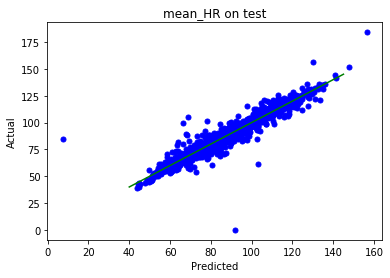

In [58]:
x = np.linspace(40, 145, 1000)
plt.plot(out1, y1, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_HR on test")
plt.plot(x, x, '-g')
plt.show()

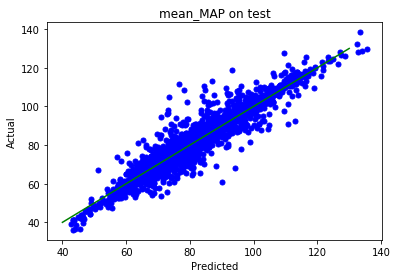

In [59]:
x = np.linspace(40, 130, 1000)
plt.plot(out2, y2, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_MAP on test")
plt.plot(x, x, '-g')
plt.show()